## Classification Performance of Aggregated Features

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import synapseclient as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

sns.set_style("darkgrid", {"axes.facecolor": ".9", 'grid.color': '.8'})
warnings.simplefilter("ignore")
%matplotlib inline

syn = sc.login()

Welcome, Aryton Tediarjo!



### Global Variables

In [2]:
AGGREGATED_FEATURES = "syn22331590"
MATCHED_HC = "syn22254800"

### Retrieve Data

In [3]:
matched_hc = pd.read_csv(
    syn.get(MATCHED_HC)["path"], sep = "\t")

In [4]:
data = pd.read_csv(syn.get(AGGREGATED_FEATURES)["path"], sep = "\t").dropna().set_index("healthCode")
feat_used = [feat for feat in data.columns 
             if ("createdOn" not in feat) 
             and ("window" not in feat) 
             and ("error" not in feat) 
             and ('nrecords' not in feat)
             and ("healthCode" not in feat) 
             and ("gender" not in feat) 
             and ("PD" not in feat) 
             and ("age" not in feat)]

data = data.join(matched_hc[["healthCode"]].set_index("healthCode"), how = "inner")

In [5]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(data[feat_used],
                                                   data['PD'],
                                                   test_size = 0.25,
                                                   random_state = 100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(337, 106)
(113, 106)
(337,)
(113,)


### Classifiers

In [7]:
clfs = []
clfs.append(LogisticRegression(random_state = 100))
clfs.append(RidgeClassifier(random_state = 100))
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier(random_state = 100))
clfs.append(RandomForestClassifier(max_depth = 5, 
                                   random_state = 100, 
                                   n_estimators = 5000))
clfs.append(GradientBoostingClassifier(max_depth = 5, 
                                       random_state = 100, 
                                       n_estimators = 5000))

### Validation Set Performance (ROC-AUC)

In [8]:
model_metrics_placeholder = {}
model_metrics_placeholder["classifier"] = []
model_metrics_placeholder["cross_validation_auc_score"] = []
model_metrics_placeholder["cross_validation_std"] = []
model_metrics_placeholder["test_auc_score"] = []

In [9]:
for classifier in clfs:
    pipeline = Pipeline([
        ('normalizer', MinMaxScaler()), 
        ('clf', classifier)])
    
    scores = cross_validate(pipeline, 
                            X_train, 
                            y_train,
                            cv = 10, 
                           scoring = "roc_auc",
                           n_jobs = -1)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
    
    model_metrics_placeholder["classifier"].append(type(classifier).__name__)
    model_metrics_placeholder["cross_validation_auc_score"].append(scores["test_score"].mean())
    model_metrics_placeholder["cross_validation_std"].append(scores["test_score"].std())

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------
fit_time  mean  0.028294706344604494
fit_time  std  0.004595044520079132
score_time  mean  0.002785038948059082
score_time  std  0.00019465483506384123
test_score  mean  0.708671679197995
test_score  std  0.08598781269903454
---------------------------------
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=100, solver='auto',
                tol=0.001)
-----------------------------------
fit_time  mean  0.006667733192443848
fit_time  std  0.0006186417668702055
score_time  mean  0.002469444274902344
score_time

### Test-set Performance (ROC-AUC)

In [10]:
for classifier in clfs:
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    pipeline = Pipeline([
        ('normalizer', MinMaxScaler()), 
        ('clf', classifier)])
    auc_score = roc_auc_score(pipeline.fit(X_train, y_train).predict(X_test), y_test)
    print("ROC-AUC Score on Test-Set %s \n \n"%auc_score)
    model_metrics_placeholder["test_auc_score"].append(auc_score)

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------
ROC-AUC Score on Test-Set 0.6549671592775042 
 

---------------------------------
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=100, solver='auto',
                tol=0.001)
-----------------------------------
ROC-AUC Score on Test-Set 0.6683150183150184 
 

---------------------------------
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=Tr

## Diagnosing Model Performance

In [11]:
pipeline = Pipeline([
        ('normalizer', MinMaxScaler()), 
        ('clf', clfs[5])])

In [12]:
model_fit = pipeline.fit(X_train, y_train)
proba = model_fit.predict_proba(X_test)
proba = pd.DataFrame(proba).rename({0:"Healthy Probability Score", 
                                    1:"PD Probability Score"}, axis = 1)
label = pd.DataFrame(y_test).reset_index(drop = True)
proba_df = pd.concat([proba, label], axis = 1)

#### a.) Assigned PD Probability between PD users and Healthy Controls (Random Forest)

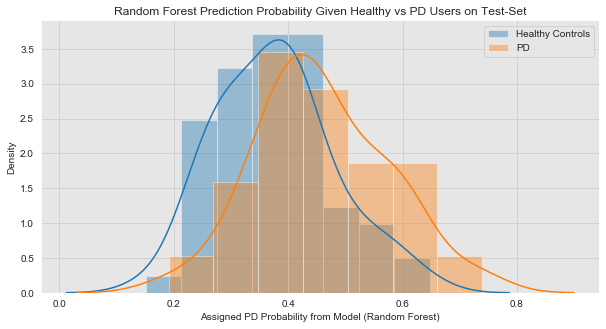

In [13]:
plt.figure(figsize = (10,5))
sns.distplot(proba_df[proba_df["PD"] == 0]["PD Probability Score"], label = "Healthy Controls")
sns.distplot(proba_df[proba_df["PD"] == 1]["PD Probability Score"], label = "PD")
sns.despine()

plt.title("Random Forest Prediction Probability Given Healthy vs PD Users on Test-Set")
plt.xlabel("Assigned PD Probability from Model (Random Forest)")
plt.ylabel("Density")
plt.legend()
plt.show()

#### b). ROC Curves (Random Forest)

In [14]:
ns_probs = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_df["PD Probability Score"])

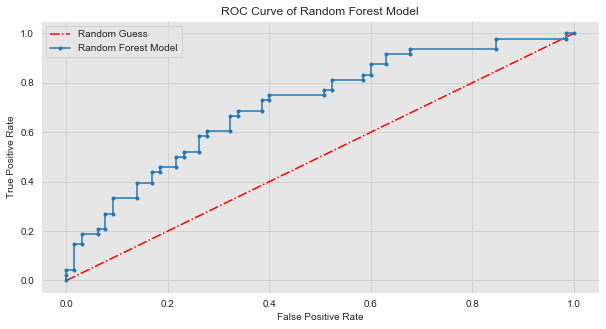

In [15]:
plt.figure(figsize = (10,5))
plt.plot(ns_fpr, ns_tpr, linestyle='-.', label='Random Guess', color = "red")
plt.plot(lr_fpr, lr_tpr, marker = ".",label='Random Forest Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve of Random Forest Model")
plt.show()